

# Importing Libraries




In [1]:
!pip install boruta category_encoders xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler, SMOTENC
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import CondensedNearestNeighbour, TomekLinks, RandomUnderSampler
from boruta import BorutaPy
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import time

import warnings
warnings.filterwarnings('ignore')

# Dataset Load & Preprocessing

In [3]:
df = pd.read_csv("/content/Sleep_health_and_lifestyle_dataset.csv")
df.fillna("None", inplace=True)

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['Sleep Disorder']
)

for d in (df_train, df_test):
    # Dividing Blood Pressure into Systolic and Diastolic BP
    d[['Systolic BP', 'Diastolic BP']] = d['Blood Pressure'].str.split('/', expand=True).astype(int)
    d.drop(['Person ID', 'Blood Pressure'], axis=1, inplace=True)

    # Labeling less number of careers as other
    d['Occupation'] = d['Occupation'].replace(['Manager', 'Sales Representative', 'Scientist', 'Software Engineer'], 'Other')

    # Adding the average BMI for the range
    d['BMI Category'] = d['BMI Category'].replace({'Normal':22, 'Normal Weight':22, 'Overweight':27, 'Obese':30})

    # Creating Interaction features
    eps = 1e-6
    d['Stress_sleep_interaction'] = d['Stress Level'] / (d['Quality of Sleep'] + eps)
    d['BMI_Activity'] = d['BMI Category'] * d['Physical Activity Level']
    d['Sleep_Heart_ratio'] = d['Sleep Duration'] / (d['Heart Rate'] + eps)
    d['Sleep_Steps_ratio'] = d['Sleep Duration'] / (d['Daily Steps'] + eps)
    d['Sleep_Stress_ratio'] = d['Sleep Duration'] / (d['Stress Level'] + eps)
    d['Pulse_Pressure'] = d['Systolic BP'] - d['Diastolic BP']
    d['log_steps'] = np.log1p(d['Daily Steps'])
    d['sqrt_sleep'] = np.sqrt(d['Sleep Duration'])
    d.replace([np.inf, -np.inf], np.nan, inplace=True)
    d.dropna(inplace=True)

# One-hot encode Occupation on train, then align test to train columns
df_train = pd.get_dummies(df_train, columns=['Occupation'], drop_first=False)
df_test  = pd.get_dummies(df_test,  columns=['Occupation'], drop_first=False)

# Ensure test has same dummy columns as train (add missing columns with 0)
df_test = df_test.reindex(columns=df_train.columns, fill_value=0)

# Label encode Gender using encoder fitted on train (no leakage)
le_gender = LabelEncoder()
df_train['Gender'] = le_gender.fit_transform(df_train['Gender'])
# transform test using the same encoder; if unseen label appears this will raise — same behavior as original approach
df_test['Gender'] = le_gender.transform(df_test['Gender'])

# Encode target (Sleep Disorder) using encoder fitted on train only
le_target = LabelEncoder()
y_train = le_target.fit_transform(df_train['Sleep Disorder'])
y_test  = le_target.transform(df_test['Sleep Disorder'])

# Prepare X_train and X_test (drop target column exactly like original)
X_train = df_train.drop('Sleep Disorder', axis=1)
X_test  = df_test.drop('Sleep Disorder', axis=1)


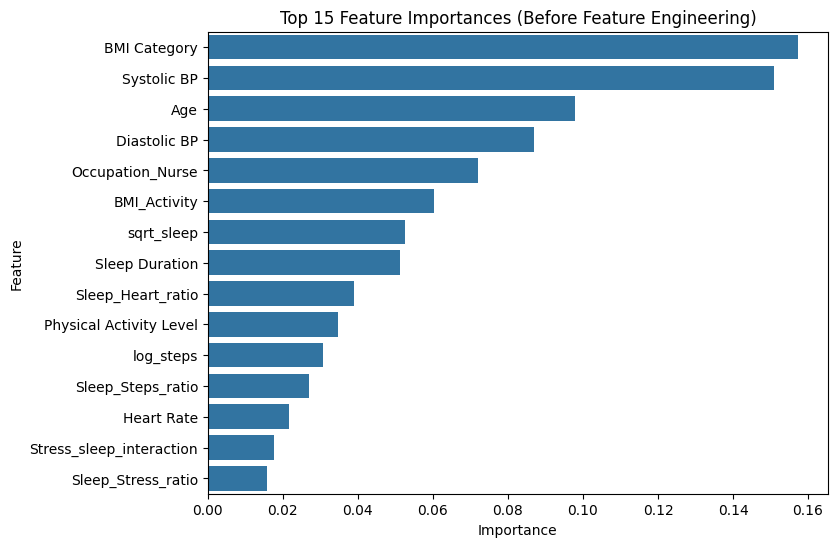

In [4]:
import seaborn as sns
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=importances[:15], y=importances.index[:15])
plt.title("Top 15 Feature Importances (Before Feature Engineering)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [5]:
df_train.shape

(299, 28)

In [6]:
classes, counts = np.unique(df_train['Gender'], return_counts=True)
print(classes, counts)

[0 1] [149 150]


# Apply RobustSclaer, MI, LDA, Boruta, Autoencoder, and SMOTETomek

In [7]:
smotetomek = SMOTETomek(sampling_strategy='auto',
                   smote=SMOTE(k_neighbors=3, random_state=42),
                   tomek=TomekLinks(sampling_strategy='auto', n_jobs=-1),
                   n_jobs=-1,
                   random_state=42)
X_train_res, y_train_res = smotetomek.fit_resample(X_train, y_train)

#### Pipeline 1 - Robustscaler -> MI - LDA  ####
#Normalize the data
scaler = RobustScaler()
X_train_robust = scaler.fit_transform(X_train)
X_test_robust = scaler.transform(X_test)

X_train_robust_resample, y_train_robust_resample = smotetomek.fit_resample(X_train_robust, y_train)

# Applying Mutual information
mi = SelectKBest(score_func=mutual_info_classif, k=5)
X_train_mi = mi.fit_transform(X_train_robust, y_train)
X_test_mi = mi.transform(X_test_robust)

# Applying LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_mi, y_train)
X_test_lda = lda.transform(X_test_mi)

# Resample MI and LDA data
X_train_mi_res, y_train_mi_res = smotetomek.fit_resample(X_train_mi, y_train)
X_train_lda_res, y_train_lda_res = smotetomek.fit_resample(X_train_lda, y_train)

#### Pipeline 2 - MinMaxscaler -> Boruta - Autoencoder  ####
#Normalize the data
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

X_train_minmax_resample, y_train_minmax_resample = smotetomek.fit_resample(X_train_minmax, y_train)

# RandomForest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Applying Boruta Feature Selection
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=0, random_state=42)

X_train_boruta = boruta_selector.fit_transform(X_train_minmax, y_train)
X_test_boruta = boruta_selector.transform(X_test_minmax)

# applying Autoencoder
n_features = X_train_boruta.shape[1]
input_layer = Input(shape=(n_features,))
encoded     = Dense(32, activation='relu')(input_layer)
bottleneck  = Dense(16, activation='relu')(encoded)
decoded     = Dense(32, activation='relu')(bottleneck)
output_layer= Dense(n_features, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
autoencoder.fit(X_train_boruta, X_train_boruta, epochs=10, batch_size=32, verbose=0)

# Encoder-only transform (you created these; keeping intact)
encoder = Model(inputs=input_layer, outputs=bottleneck)
X_train_encoded = encoder.predict(X_train_boruta)
X_test_encoded  = encoder.predict(X_test_boruta)

# Resample MI and LDA data
X_train_boruta_res, y_train_boruta_res = smotetomek.fit_resample(X_train_boruta, y_train)
X_train_encoded_res, y_train_encoded_res = smotetomek.fit_resample(X_train_encoded, y_train)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [8]:
classes, counts = np.unique(y_train_res, return_counts=True)
print(classes, counts)

[0 1 2] [175 173 171]


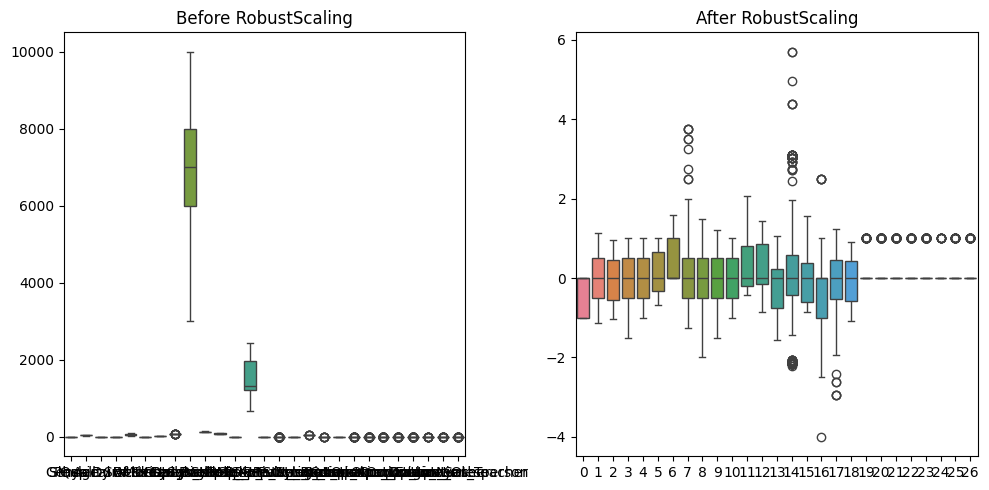

In [9]:
import seaborn as sns
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title('Before RobustScaling')

plt.subplot(1,2,2)
sns.boxplot(data=X_train_robust)
plt.title('After RobustScaling')

plt.tight_layout()
plt.show()

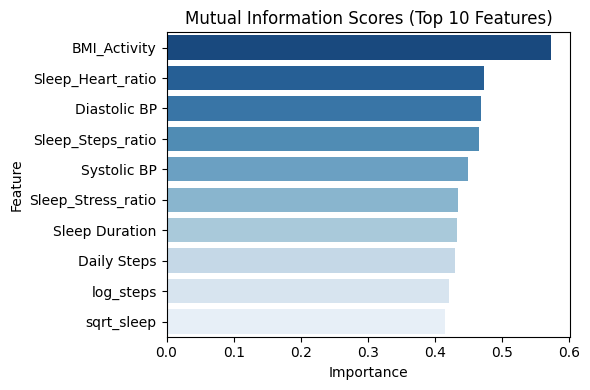

In [10]:
mi_scores = mutual_info_classif(X_train, y_train)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'Score': mi_scores})
mi_df = mi_df.sort_values('Score', ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x='Score', y='Feature', data=mi_df.head(10), palette='Blues_r')
plt.title('Mutual Information Scores (Top 10 Features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

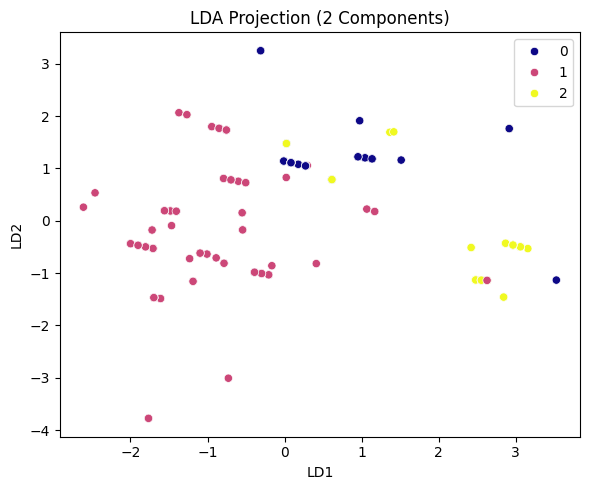

In [11]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_train_lda[:,0], y=X_train_lda[:,1], hue=y_train, palette='plasma')
plt.title('LDA Projection (2 Components)')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.tight_layout()
plt.show()

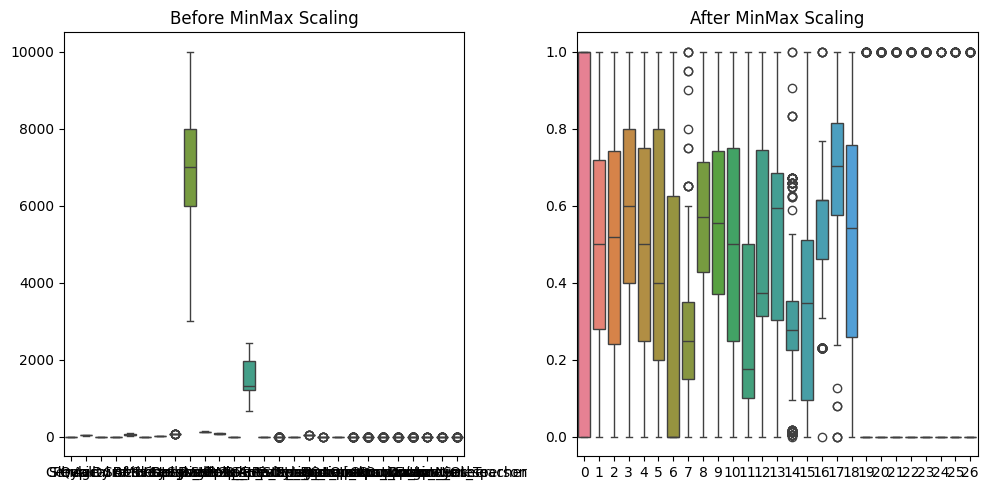

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title('Before MinMax Scaling')

plt.subplot(1,2,2)
sns.boxplot(data=X_train_minmax)
plt.title('After MinMax Scaling')

plt.tight_layout()
plt.show()

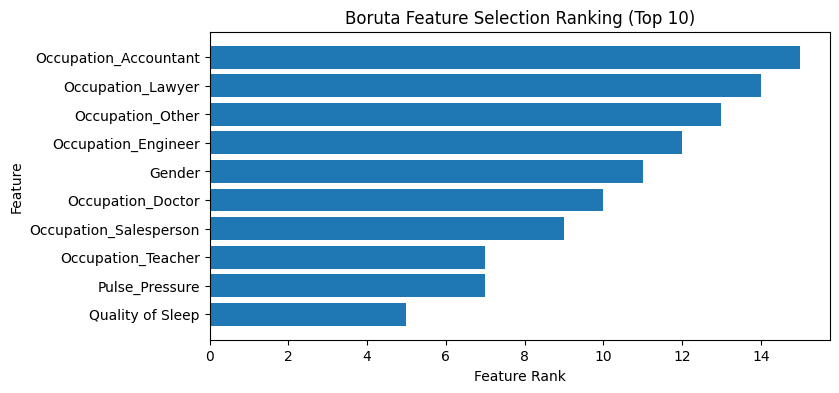

In [13]:
feature_ranks = pd.DataFrame({
    'Feature': X_train.columns,
    'Rank': boruta_selector.ranking_,
    'Selected': boruta_selector.support_
}).sort_values('Rank', ascending=False)

plt.figure(figsize=(8, 4))
plt.barh(feature_ranks['Feature'][:10], feature_ranks['Rank'][:10])
plt.xlabel('Feature Rank')
plt.ylabel('Feature')
plt.title('Boruta Feature Selection Ranking (Top 10)')
plt.gca().invert_yaxis()
plt.show()

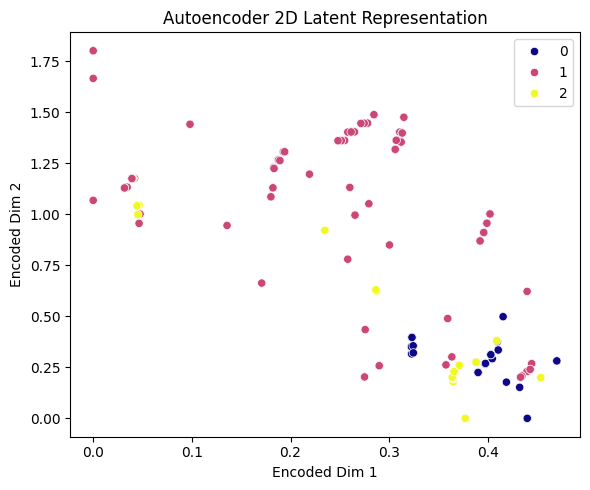

In [14]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_train_encoded[:,0], y=X_train_encoded[:,1], hue=y_train, palette='plasma')
plt.title('Autoencoder 2D Latent Representation')
plt.xlabel('Encoded Dim 1')
plt.ylabel('Encoded Dim 2')
plt.tight_layout()
plt.show()

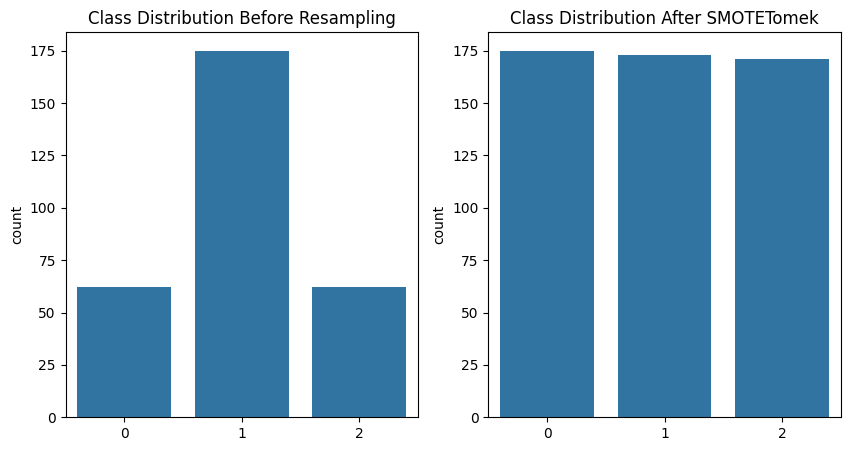

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x=y_train)
plt.title('Class Distribution Before Resampling')

plt.subplot(1,2,2)
sns.countplot(x=y_train_res)
plt.title('Class Distribution After SMOTETomek')
# plt.tight_layout()
plt.show()

# ML Model Result Storage

In [16]:
ML_Model = []
ML_Config = []
accuracy = []
f1_score = []
recall = []
precision = []
auc_roc = []  # Adding a holder for AUC-ROC

# Function to call for storing the results
def storeResults(model, config, a, b, c, d, e):
    """
    Store model performance results

    Parameters:
    model: Name of the ML model
    config: Configuration name (preprocessing steps applied)
    a: Accuracy score
    b: F1 score
    c: Recall score
    d: Precision score
    e: AUC-ROC score
    """
    ML_Model.append(model)
    ML_Config.append(config)
    accuracy.append(round(a, 6))
    f1_score.append(round(b, 6))
    recall.append(round(c, 6))
    precision.append(round(d, 6))
    auc_roc.append(round(e, 6))

# Logistic Regression

In [17]:
configurations = []

configurations.append(('Original Data', X_train, X_test, y_train))
configurations.append(('SMOTETomek', X_train_res, X_test, y_train_res))
configurations.append(('Normalized Data with RobustScaler', X_train_robust, X_test_robust, y_train))
configurations.append(('SMOTETomek + RobustScaler', X_train_robust_resample, X_test_robust, y_train_robust_resample))
configurations.append(('MI', X_train_mi, X_test_mi, y_train))
configurations.append(('MI + SMOTETomek', X_train_mi_res, X_test_mi, y_train_mi_res))
configurations.append(('LDA', X_train_lda, X_test_lda, y_train))
configurations.append(('LDA + SMOTETomek', X_train_lda_res, X_test_lda, y_train_lda_res))
configurations.append(('Normalized Data with MinMaxScaler', X_train_minmax, X_test_minmax, y_train))
configurations.append(('SMOTETomek + MiMaxScaler', X_train_minmax_resample, X_test_minmax, y_train_minmax_resample))
configurations.append(('Boruta', X_train_boruta, X_test_boruta, y_train))
configurations.append(('Boruta + SMOTETomek', X_train_boruta_res, X_test_boruta, y_train_boruta_res))
configurations.append(('Autoencoder', X_train_encoded, X_test_encoded, y_train))
configurations.append(('Autoencoder + SMOTETomek', X_train_encoded_res, X_test_encoded, y_train_encoded_res))

params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.linspace(0.01, 100, 10),
    'max_iter': range(300, 1000, 10),
    'solver': ['lbfgs', 'liblinear', 'saga']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Logistic Regression with {name} configuration...")
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    logr = RandomizedSearchCV(LogisticRegression(), params, cv=cv, n_iter=50,
                             n_jobs=-1, scoring=['accuracy', 'f1_macro'], refit='f1_macro', verbose=2)
    train_start = time.time()
    logr.fit(X_train_cfg, y_train_cfg)
    train_time = time.time() - train_start

    pred_start = time.time()
    y_train_lr = logr.predict(X_train_cfg)
    y_test_lr = logr.predict(X_test_cfg)
    y_train_lr_proba = logr.predict_proba(X_train_cfg)
    y_test_lr_proba = logr.predict_proba(X_test_cfg)
    predict_time = time.time() - pred_start

    metrics_dict = {
          "Dataset": ["Training", "Test"],
          "Accuracy": [
              metrics.accuracy_score(y_train_cfg, y_train_lr),
              metrics.accuracy_score(y_test, y_test_lr),
          ],
          "F1 Score": [
              metrics.f1_score(y_train_cfg, y_train_lr, average='macro'),
              metrics.f1_score(y_test, y_test_lr, average='macro'),
          ],
          "Recall": [
              metrics.recall_score(y_train_cfg, y_train_lr, average='macro'),
              metrics.recall_score(y_test, y_test_lr, average='macro'),
          ],
          "Precision": [
              metrics.precision_score(y_train_cfg, y_train_lr, average='macro'),
              metrics.precision_score(y_test, y_test_lr, average='macro'),
          ],
          "AUC-ROC": [
              metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_lr_proba, multi_class='ovr', average='macro'),
              metrics.roc_auc_score(pd.get_dummies(y_test), y_test_lr_proba, multi_class='ovr', average='macro'),
          ]
      }

    df_metrics = pd.DataFrame(metrics_dict)
    print("\nLogistic Regression Model Performance Metrics")
    print("Configuration Name: ", name)
    print(df_metrics.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_lr_proba, multi_class='ovr', average='macro')
    storeResults(
          'Logistic Regression',
          name,
          metrics.accuracy_score(y_test, y_test_lr),
          metrics.f1_score(y_test, y_test_lr, average='macro'),
          metrics.recall_score(y_test, y_test_lr, average='macro'),
          metrics.precision_score(y_test, y_test_lr, average='macro'),
          auc_score
      )
    print("Best hyperparameters found by RandomizedSearchCV:")
    print(logr.best_params_)
    print(f"Total training time for this configuration: {train_time} seconds")
    print(f"Total prediction time for this configuration: {predict_time} seconds")



Running Logistic Regression with Original Data configuration...
Fitting 8 folds for each of 50 candidates, totalling 400 fits

Logistic Regression Model Performance Metrics
Configuration Name:  Original Data
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.913043  0.895726 0.891459   0.900717 0.955996
    Test  0.973333  0.956583 0.955556   0.962963 0.998183
Best hyperparameters found by RandomizedSearchCV:
{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 750, 'C': np.float64(100.0)}
Total training time for this configuration: 52.32167840003967 seconds
Total prediction time for this configuration: 0.006640434265136719 seconds

Running Logistic Regression with SMOTETomek configuration...
Fitting 8 folds for each of 50 candidates, totalling 400 fits

Logistic Regression Model Performance Metrics
Configuration Name:  SMOTETomek
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.946050  0.946135 0.946179   0.946386 0.975726
    Test  0.973333  0

# KNN

In [18]:
configurations = []

configurations.append(('Original Data', X_train, X_test, y_train))
configurations.append(('SMOTETomek', X_train_res, X_test, y_train_res))
configurations.append(('Normalized Data with RobustScaler', X_train_robust, X_test_robust, y_train))
configurations.append(('SMOTETomek + RobustScaler', X_train_robust_resample, X_test_robust, y_train_robust_resample))
configurations.append(('MI', X_train_mi, X_test_mi, y_train))
configurations.append(('MI + SMOTETomek', X_train_mi_res, X_test_mi, y_train_mi_res))
configurations.append(('LDA', X_train_lda, X_test_lda, y_train))
configurations.append(('LDA + SMOTETomek', X_train_lda_res, X_test_lda, y_train_lda_res))
configurations.append(('Normalized Data with MinMaxScaler', X_train_minmax, X_test_minmax, y_train))
configurations.append(('SMOTETomek + MiMaxScaler', X_train_minmax_resample, X_test_minmax, y_train_minmax_resample))
configurations.append(('Boruta', X_train_boruta, X_test_boruta, y_train))
configurations.append(('Boruta + SMOTETomek', X_train_boruta_res, X_test_boruta, y_train_boruta_res))
configurations.append(('Autoencoder', X_train_encoded, X_test_encoded, y_train))
configurations.append(('Autoencoder + SMOTETomek', X_train_encoded_res, X_test_encoded, y_train_encoded_res))

params = {
    'n_neighbors': np.random.randint(2, 50, 3),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': np.random.randint(1, 5, 1)
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning KNN with {name} configuration...")
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    knn = RandomizedSearchCV(KNeighborsClassifier(), params, cv=cv, n_iter=50,
                             n_jobs=-1, scoring=['accuracy', 'f1_macro'], refit='f1_macro', verbose=2)

    train_start = time.time()
    knn.fit(X_train_cfg, y_train_cfg)
    train_time = time.time() - train_start

    pred_start = time.time()

    y_train_knn = knn.predict(X_train_cfg)
    y_test_knn = knn.predict(X_test_cfg)
    y_train_knn_proba = knn.predict_proba(X_train_cfg)
    y_test_knn_proba = knn.predict_proba(X_test_cfg)
    predict_time = time.time() - pred_start

    metrics_dict = {
          "Dataset": ["Training", "Test"],
          "Accuracy": [
              metrics.accuracy_score(y_train_cfg, y_train_knn),
              metrics.accuracy_score(y_test, y_test_knn),
          ],
          "F1 Score": [
              metrics.f1_score(y_train_cfg, y_train_knn, average='macro'),
              metrics.f1_score(y_test, y_test_knn, average='macro'),
          ],
          "Recall": [
              metrics.recall_score(y_train_cfg, y_train_knn, average='macro'),
              metrics.recall_score(y_test, y_test_knn, average='macro'),
          ],
          "Precision": [
              metrics.precision_score(y_train_cfg, y_train_knn, average='macro'),
              metrics.precision_score(y_test, y_test_knn, average='macro'),
          ],
          "AUC-ROC": [
              metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_knn_proba, multi_class='ovr', average='macro'),
              metrics.roc_auc_score(pd.get_dummies(y_test), y_test_knn_proba, multi_class='ovr', average='macro'),
          ]
      }

    df_metrics = pd.DataFrame(metrics_dict)
    print("\nKNearestNeighbors Model Performance Metrics")
    print("Configuration Name: ", name)
    print(df_metrics.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_knn_proba, multi_class='ovr', average='macro')
    storeResults(
          'K-Nearest Neighbors',
          name,
          metrics.accuracy_score(y_test, y_test_knn),
          metrics.f1_score(y_test, y_test_knn, average='macro'),
          metrics.recall_score(y_test, y_test_knn, average='macro'),
          metrics.precision_score(y_test, y_test_knn, average='macro'),
          auc_score
      )
    print("Best hyperparameters found by RandomizedSearchCV:")
    print(knn.best_params_)
    print(f"Total training time for this configuration: {train_time} seconds")
    print(f"Total prediction time for this configuration: {predict_time} seconds")



Running KNN with Original Data configuration...
Fitting 8 folds for each of 24 candidates, totalling 192 fits

KNearestNeighbors Model Performance Metrics
Configuration Name:  Original Data
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.923077  0.908611 0.904117   0.913518 0.987279
    Test  0.920000  0.900430 0.911995   0.890348 0.952559
Best hyperparameters found by RandomizedSearchCV:
{'weights': 'distance', 'p': np.int64(3), 'n_neighbors': np.int64(30), 'metric': 'euclidean'}
Total training time for this configuration: 1.751286506652832 seconds
Total prediction time for this configuration: 0.01852869987487793 seconds

Running KNN with SMOTETomek configuration...
Fitting 8 folds for each of 24 candidates, totalling 192 fits

KNearestNeighbors Model Performance Metrics
Configuration Name:  SMOTETomek
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.953757  0.953820 0.953798   0.954009 0.995043
    Test  0.933333  0.916266 0.934217   0.9019

# Random Forest

In [19]:
configurations = []

configurations.append(('Original Data', X_train, X_test, y_train))
configurations.append(('SMOTETomek', X_train_res, X_test, y_train_res))
configurations.append(('Normalized Data with RobustScaler', X_train_robust, X_test_robust, y_train))
configurations.append(('SMOTETomek + RobustScaler', X_train_robust_resample, X_test_robust, y_train_robust_resample))
configurations.append(('MI', X_train_mi, X_test_mi, y_train))
configurations.append(('MI + SMOTETomek', X_train_mi_res, X_test_mi, y_train_mi_res))
configurations.append(('LDA', X_train_lda, X_test_lda, y_train))
configurations.append(('LDA + SMOTETomek', X_train_lda_res, X_test_lda, y_train_lda_res))
configurations.append(('Normalized Data with MinMaxScaler', X_train_minmax, X_test_minmax, y_train))
configurations.append(('SMOTETomek + MiMaxScaler', X_train_minmax_resample, X_test_minmax, y_train_minmax_resample))
configurations.append(('Boruta', X_train_boruta, X_test_boruta, y_train))
configurations.append(('Boruta + SMOTETomek', X_train_boruta_res, X_test_boruta, y_train_boruta_res))
configurations.append(('Autoencoder', X_train_encoded, X_test_encoded, y_train))
configurations.append(('Autoencoder + SMOTETomek', X_train_encoded_res, X_test_encoded, y_train_encoded_res))

selected_features = boruta_selector.support_
optimal_features = sum(selected_features)
print(f"Optimal number of features to select using Boruta: {optimal_features}")

# Step 4: Random Forest + GridSearchCV
print("\n=== Random Forest Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': range(100, 160, 3),
    'max_depth': range(2, 20, 3),
    'min_samples_split': range(3, 7, 1),
    'min_samples_leaf': range(3, 7, 1),
    'max_features': ['sqrt'],
    'bootstrap': [False],
    'class_weight': ['balanced'],
    'max_leaf_nodes': range(20, 40, 5),
    'min_impurity_decrease': np.linspace(0.001, 0.05, 3),
    'ccp_alpha': np.linspace(0.001, 0.07, 3),
    'criterion': ['gini', 'entropy', 'log_loss']
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Random Forest with {name} configuration...")
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, n_jobs=-1,
                            n_iter=50, scoring=['accuracy', 'f1_macro'], refit='f1_macro', verbose=2)
    train_start = time.time()
    rf.fit(X_train_cfg, y_train_cfg)
    train_time = time.time() - train_start

    pred_start = time.time()
    y_train_rf = rf.predict(X_train_cfg)
    y_test_rf = rf.predict(X_test_cfg)
    y_train_rf_proba = rf.predict_proba(X_train_cfg)
    y_test_rf_proba = rf.predict_proba(X_test_cfg)
    predict_time = time.time() - pred_start

    metrics_dict = {
          "Dataset": ["Training", "Test"],
          "Accuracy": [
              metrics.accuracy_score(y_train_cfg, y_train_rf),
              metrics.accuracy_score(y_test, y_test_rf),
          ],
          "F1 Score": [
              metrics.f1_score(y_train_cfg, y_train_rf, average='macro'),
              metrics.f1_score(y_test, y_test_rf, average='macro'),
          ],
          "Recall": [
              metrics.recall_score(y_train_cfg, y_train_rf, average='macro'),
              metrics.recall_score(y_test, y_test_rf, average='macro'),
          ],
          "Precision": [
              metrics.precision_score(y_train_cfg, y_train_rf, average='macro'),
              metrics.precision_score(y_test, y_test_rf, average='macro'),
          ],
          "AUC-ROC": [
              metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_rf_proba, multi_class='ovr', average='macro'),
              metrics.roc_auc_score(pd.get_dummies(y_test), y_test_rf_proba, multi_class='ovr', average='macro'),
          ]
      }

    df_metrics = pd.DataFrame(metrics_dict)
    print("\nRandom Forest Model Performance Metrics")
    print("Configuration Name: ", name)
    print(df_metrics.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_rf_proba, multi_class='ovr', average='macro')
    storeResults(
          'Random Forest',
          name,
          metrics.accuracy_score(y_test, y_test_rf),
          metrics.f1_score(y_test, y_test_rf, average='macro'),
          metrics.recall_score(y_test, y_test_rf, average='macro'),
          metrics.precision_score(y_test, y_test_rf, average='macro'),
          auc_score
      )
    print("Best hyperparameters found by RandomizedSearchCV:")
    print(rf.best_params_)
    print(f"Total training time for this configuration: {train_time} seconds")
    print(f"Total prediction time for this configuration: {predict_time} seconds")


Optimal number of features to select using Boruta: 11

=== Random Forest Model Performance with Hyperparameter Tuning ===

Running Random Forest with Original Data configuration...
Fitting 8 folds for each of 50 candidates, totalling 400 fits

Random Forest Model Performance Metrics
Configuration Name:  Original Data
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.896321  0.868555 0.864578   0.872917 0.940014
    Test  0.946667  0.913165 0.912500   0.918803 0.995633
Best hyperparameters found by RandomizedSearchCV:
{'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 5, 'min_impurity_decrease': np.float64(0.05), 'max_leaf_nodes': 30, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'log_loss', 'class_weight': 'balanced', 'ccp_alpha': np.float64(0.001), 'bootstrap': False}
Total training time for this configuration: 74.7789876461029 seconds
Total prediction time for this configuration: 0.03854203224182129 seconds

Running Random Forest with SMOTETo

# XGBoost




In [20]:
configurations = []

configurations.append(('Original Data', X_train, X_test, y_train))
configurations.append(('SMOTETomek', X_train_res, X_test, y_train_res))
configurations.append(('Normalized Data with RobustScaler', X_train_robust, X_test_robust, y_train))
configurations.append(('SMOTETomek + RobustScaler', X_train_robust_resample, X_test_robust, y_train_robust_resample))
configurations.append(('MI', X_train_mi, X_test_mi, y_train))
configurations.append(('MI + SMOTETomek', X_train_mi_res, X_test_mi, y_train_mi_res))
configurations.append(('LDA', X_train_lda, X_test_lda, y_train))
configurations.append(('LDA + SMOTETomek', X_train_lda_res, X_test_lda, y_train_lda_res))
configurations.append(('Normalized Data with MinMaxScaler', X_train_minmax, X_test_minmax, y_train))
configurations.append(('SMOTETomek + MiMaxScaler', X_train_minmax_resample, X_test_minmax, y_train_minmax_resample))
configurations.append(('Boruta', X_train_boruta, X_test_boruta, y_train))
configurations.append(('Boruta + SMOTETomek', X_train_boruta_res, X_test_boruta, y_train_boruta_res))
configurations.append(('Autoencoder', X_train_encoded, X_test_encoded, y_train))
configurations.append(('Autoencoder + SMOTETomek', X_train_encoded_res, X_test_encoded, y_train_encoded_res))

selected_features = boruta_selector.support_
optimal_features = sum(selected_features)
print(f"Optimal number of features to select using Boruta: {optimal_features}")

# Step 4: XGBoost + GridSearchCV
print("\n=== XGBoost Model Performance with Hyperparameter Tuning ===")

# param_grid = {
#     'booster': ['gbtree', 'dart'],
#     'learning_rate': np.linspace(0.0001, 0.1, 10),
#     'n_estimators': range(50, 500, 10),
#     'max_depth': range(2, 50, 10),
#     'min_child_weight': range(1, 10, 1),
#     'gamma': np.linspace(0.1, 1, 1),
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],

#     'rate_drop': [0.1, 0.3, 0.5],
#     'skip_drop': [0.1, 0.3, 0.5],

# }

param_grid = [
    {
        'booster': ['gbtree'],
        'learning_rate': np.linspace(0.0001, 0.1, 10),
        'n_estimators': range(50, 500, 50),  # Reduced step size for faster search
        'max_depth': range(2, 50, 10),
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.5, 1],
        'min_child_weight': [1, 3, 5]
    },
    {
        'booster': ['dart'],
        'learning_rate': np.linspace(0.0001, 0.1, 10),
        'n_estimators': range(50, 500, 50),
        'max_depth': range(2, 50, 10),
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.5, 1],
        'min_child_weight': [1, 3, 5],
        'rate_drop': [0.1, 0.3, 0.5],
        'skip_drop': [0.1, 0.3, 0.5]
    },
    {
        'booster': ['gblinear'],
        'learning_rate': np.linspace(0.0001, 0.1, 10),
        'n_estimators': range(50, 500, 50),
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [0, 0.01, 0.1, 1]
        # No max_depth for gblinear (it's a linear model)
    }
]

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning XGBoost with {name} configuration...")
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    xgb = RandomizedSearchCV(XGBClassifier(), param_grid, n_iter=50, cv=cv,
                             n_jobs=-1, scoring=['accuracy', 'f1_macro'], refit='f1_macro', verbose=2)

    train_start = time.time()
    xgb.fit(X_train_cfg, y_train_cfg)
    train_time = time.time() - train_start

    pred_start = time.time()
    y_train_xg = xgb.predict(X_train_cfg)
    y_test_xg = xgb.predict(X_test_cfg)
    y_train_xg_proba = xgb.predict_proba(X_train_cfg)
    y_test_xg_proba = xgb.predict_proba(X_test_cfg)
    predict_time = time.time() - pred_start

    metrics_dict = {
          "Dataset": ["Training", "Test"],
          "Accuracy": [
              metrics.accuracy_score(y_train_cfg, y_train_xg),
              metrics.accuracy_score(y_test, y_test_xg),
          ],
          "F1 Score": [
              metrics.f1_score(y_train_cfg, y_train_xg, average='macro'),
              metrics.f1_score(y_test, y_test_xg, average='macro'),
          ],
          "Recall": [
              metrics.recall_score(y_train_cfg, y_train_xg, average='macro'),
              metrics.recall_score(y_test, y_test_xg, average='macro'),
          ],
          "Precision": [
              metrics.precision_score(y_train_cfg, y_train_xg, average='macro'),
              metrics.precision_score(y_test, y_test_xg, average='macro'),
          ],
          "AUC-ROC": [
              metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_xg_proba, multi_class='ovr', average='macro'),
              metrics.roc_auc_score(pd.get_dummies(y_test), y_test_xg_proba, multi_class='ovr', average='macro'),
          ]
      }

    df_metrics = pd.DataFrame(metrics_dict)
    print("\nXGBoost Model Performance Metrics")
    print("Configuration Name: ", name)
    print(df_metrics.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_xg_proba, multi_class='ovr', average='macro')
    storeResults(
        'XGBoost Model',
        name,
        metrics.accuracy_score(y_test, y_test_xg),
        metrics.f1_score(y_test, y_test_xg, average='macro'),
        metrics.recall_score(y_test, y_test_xg, average='macro'),
        metrics.precision_score(y_test, y_test_xg, average='macro'),
        auc_score
    )
    print("Best hyperparameters found by RandomizedSearchCV:")
    print(xgb.best_params_)
    print(f"Total training time for this configuration: {train_time} seconds")
    print(f"Total prediction time for this configuration: {predict_time} seconds")


Optimal number of features to select using Boruta: 11

=== XGBoost Model Performance with Hyperparameter Tuning ===

Running XGBoost with Original Data configuration...
Fitting 8 folds for each of 50 candidates, totalling 400 fits

XGBoost Model Performance Metrics
Configuration Name:  Original Data
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.916388  0.901116 0.896836   0.906622 0.981343
    Test  0.960000  0.935214 0.934722   0.936975 0.995676
Best hyperparameters found by RandomizedSearchCV:
{'subsample': 0.8, 'skip_drop': 0.5, 'rate_drop': 0.1, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': np.float64(0.0889), 'gamma': 0.1, 'colsample_bytree': 0.6, 'booster': 'dart'}
Total training time for this configuration: 1924.867332458496 seconds
Total prediction time for this configuration: 0.2968940734863281 seconds

Running XGBoost with SMOTETomek configuration...
Fitting 8 folds for each of 50 candidates, totalling 400 fits

XGBoost M

# Gradient Boosting

In [21]:
configurations = []

configurations.append(('Original Data', X_train, X_test, y_train))
configurations.append(('SMOTETomek', X_train_res, X_test, y_train_res))
configurations.append(('Normalized Data with RobustScaler', X_train_robust, X_test_robust, y_train))
configurations.append(('SMOTETomek + RobustScaler', X_train_robust_resample, X_test_robust, y_train_robust_resample))
configurations.append(('MI', X_train_mi, X_test_mi, y_train))
configurations.append(('MI + SMOTETomek', X_train_mi_res, X_test_mi, y_train_mi_res))
configurations.append(('LDA', X_train_lda, X_test_lda, y_train))
configurations.append(('LDA + SMOTETomek', X_train_lda_res, X_test_lda, y_train_lda_res))
configurations.append(('Normalized Data with MinMaxScaler', X_train_minmax, X_test_minmax, y_train))
configurations.append(('SMOTETomek + MiMaxScaler', X_train_minmax_resample, X_test_minmax, y_train_minmax_resample))
configurations.append(('Boruta', X_train_boruta, X_test_boruta, y_train))
configurations.append(('Boruta + SMOTETomek', X_train_boruta_res, X_test_boruta, y_train_boruta_res))
configurations.append(('Autoencoder', X_train_encoded, X_test_encoded, y_train))
configurations.append(('Autoencoder + SMOTETomek', X_train_encoded_res, X_test_encoded, y_train_encoded_res))

selected_features = boruta_selector.support_
optimal_features = sum(selected_features)
print(f"Optimal number of features to select using Boruta: {optimal_features}")

# Step 4: Gradient Boosting + GridSearchCV
print("\n=== Gradient Boosting Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'loss': ['log_loss'],
    'learning_rate': np.linspace(0.0001, 0.1, 10),
    'n_estimators': range(40, 400, 10),
    'subsample': np.linspace(0.1, 0.9, 3),
    'max_depth': range(20, 60, 5),
    'init': [None],
    'max_leaf_nodes': [None],
    'min_samples_split': range(2, 20, 3),
    'min_samples_leaf': range(2, 10, 3),
    'min_weight_fraction_leaf': [0.0],
    'min_impurity_decrease': [0.0],
    'validation_fraction': [0.1],
    'n_iter_no_change': [None],
    'tol': np.linspace(0.001, 0.05, 5),
    'ccp_alpha': np.linspace(0.005, 0.05, 5),
    'max_features': ['sqrt'],
    'verbose': [0],
    'warm_start': [False],
    'criterion': ['friedman_mse'],
    # 'random_state': [0]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Gradient Boosting with {name} configuration...")
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    gbc = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, cv=cv,
                             n_iter=50, n_jobs=-1, scoring=['accuracy', 'f1_macro'], refit='f1_macro', verbose=2)
    train_start = time.time()
    gbc.fit(X_train_cfg, y_train_cfg)
    train_time = time.time() - train_start

    pred_start = time.time()
    y_train_gb = gbc.predict(X_train_cfg)
    y_test_gb = gbc.predict(X_test_cfg)
    y_train_gb_proba = gbc.predict_proba(X_train_cfg)
    y_test_gb_proba = gbc.predict_proba(X_test_cfg)
    predict_time = time.time() - pred_start

    metrics_dict = {
          "Dataset": ["Training", "Test"],
          "Accuracy": [
              metrics.accuracy_score(y_train_cfg, y_train_gb),
              metrics.accuracy_score(y_test, y_test_gb),
          ],
          "F1 Score": [
              metrics.f1_score(y_train_cfg, y_train_gb, average='macro'),
              metrics.f1_score(y_test, y_test_gb, average='macro'),
          ],
          "Recall": [
              metrics.recall_score(y_train_cfg, y_train_gb, average='macro'),
              metrics.recall_score(y_test, y_test_gb, average='macro'),
          ],
          "Precision": [
              metrics.precision_score(y_train_cfg, y_train_gb, average='macro'),
              metrics.precision_score(y_test, y_test_gb, average='macro'),
          ],
          "AUC-ROC": [
              metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_gb_proba, multi_class='ovr', average='macro'),
              metrics.roc_auc_score(pd.get_dummies(y_test), y_test_gb_proba, multi_class='ovr', average='macro'),
          ]
      }

    df_metrics = pd.DataFrame(metrics_dict)
    print("\nGradien Boosting Model Performance Metrics")
    print("Configuration Name: ", name)
    print(df_metrics.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_gb_proba, multi_class='ovr', average='macro')
    storeResults(
          'Gradient Boosting',
          name,
          metrics.accuracy_score(y_test, y_test_gb),
          metrics.f1_score(y_test, y_test_gb, average='macro'),
          metrics.recall_score(y_test, y_test_gb, average='macro'),
          metrics.precision_score(y_test, y_test_gb, average='macro'),
          auc_score
      )
    print("Best hyperparameters found by RandomizedSearchCV:")
    print(gbc.best_params_)
    print(f"Total training time for this configuration: {train_time} seconds")
    print(f"Total prediction time for this configuration: {predict_time} seconds")


Optimal number of features to select using Boruta: 11

=== Gradient Boosting Model Performance with Hyperparameter Tuning ===

Running Gradient Boosting with Original Data configuration...
Fitting 8 folds for each of 50 candidates, totalling 400 fits

Gradien Boosting Model Performance Metrics
Configuration Name:  Original Data
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.913043  0.895726 0.891459   0.900717 0.940238
    Test  0.960000  0.935214 0.934722   0.936975 0.997830
Best hyperparameters found by RandomizedSearchCV:
{'warm_start': False, 'verbose': 0, 'validation_fraction': 0.1, 'tol': np.float64(0.025500000000000002), 'subsample': np.float64(0.5), 'n_iter_no_change': None, 'n_estimators': 240, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 30, 'loss': 'log_loss', 'learning_rate': np.float64(0.07780000000000001), 'init': None, 'crit

# Extra Trees

In [22]:
configurations = []
configurations.append(('Original Data', X_train, X_test, y_train))
configurations.append(('SMOTETomek', X_train_res, X_test, y_train_res))
configurations.append(('Normalized Data with RobustScaler', X_train_robust, X_test_robust, y_train))
configurations.append(('SMOTETomek + RobustScaler', X_train_robust_resample, X_test_robust, y_train_robust_resample))
configurations.append(('MI', X_train_mi, X_test_mi, y_train))
configurations.append(('MI + SMOTETomek', X_train_mi_res, X_test_mi, y_train_mi_res))
configurations.append(('LDA', X_train_lda, X_test_lda, y_train))
configurations.append(('LDA + SMOTETomek', X_train_lda_res, X_test_lda, y_train_lda_res))
configurations.append(('Normalized Data with MinMaxScaler', X_train_minmax, X_test_minmax, y_train))
configurations.append(('SMOTETomek + MiMaxScaler', X_train_minmax_resample, X_test_minmax, y_train_minmax_resample))
configurations.append(('Boruta', X_train_boruta, X_test_boruta, y_train))
configurations.append(('Boruta + SMOTETomek', X_train_boruta_res, X_test_boruta, y_train_boruta_res))
configurations.append(('Autoencoder', X_train_encoded, X_test_encoded, y_train))
configurations.append(('Autoencoder + SMOTETomek', X_train_encoded_res, X_test_encoded, y_train_encoded_res))

selected_features = boruta_selector.support_
optimal_features = sum(selected_features)
print(f"Optimal number of features to select using Boruta: {optimal_features}")

# Step 4: Extra Trees + GridSearchCV
print("\n=== Extra Trees Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': range(300, 500, 13),
    'max_depth': range(30, 50, 3),
    'max_leaf_nodes': range(30, 60, 8),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'min_weight_fraction_leaf': [0.0],
    'min_impurity_decrease': [0.0],
    'ccp_alpha': np.linspace(0.001, 0.05, 11),
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'criterion': ['gini', 'log_loss'],
    # 'random_state': range(2, 10, 1),
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Extra Trees with {name} configuration...")
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    etc = RandomizedSearchCV(ExtraTreesClassifier(), param_grid, cv=cv, n_iter=50,
                             n_jobs=-1, scoring=["accuracy", "f1_macro"], refit='f1_macro', verbose=2)
    train_start = time.time()
    etc.fit(X_train_cfg, y_train_cfg)
    train_time = time.time() - train_start

    pred_start = time.time()
    y_train_et = etc.predict(X_train_cfg)
    y_test_et = etc.predict(X_test_cfg)
    y_train_et_proba = etc.predict_proba(X_train_cfg)
    y_test_et_proba = etc.predict_proba(X_test_cfg)
    predict_time = time.time() - pred_start

    metrics_dict = {
          "Dataset": ["Training", "Test"],
          "Accuracy": [
              metrics.accuracy_score(y_train_cfg, y_train_et),
              metrics.accuracy_score(y_test, y_test_et),
          ],
          "F1 Score": [
              metrics.f1_score(y_train_cfg, y_train_et, average='macro'),
              metrics.f1_score(y_test, y_test_et, average='macro'),
          ],
          "Recall": [
              metrics.recall_score(y_train_cfg, y_train_et, average='macro'),
              metrics.recall_score(y_test, y_test_et, average='macro'),
          ],
          "Precision": [
              metrics.precision_score(y_train_cfg, y_train_et, average='macro'),
              metrics.precision_score(y_test, y_test_et, average='macro'),
          ],
          "AUC-ROC": [
              metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_et_proba, multi_class='ovr', average='macro'),
              metrics.roc_auc_score(pd.get_dummies(y_test), y_test_et_proba, multi_class='ovr', average='macro'),
          ]
      }

    df_metrics = pd.DataFrame(metrics_dict)
    print("\nExtraTrees Model Performance Metrics")
    print("Configuration Name: ", name)
    print(df_metrics.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_et_proba, multi_class='ovr', average='macro')
    storeResults(
          'Extra Trees',
          name,
          metrics.accuracy_score(y_test, y_test_et),
          metrics.f1_score(y_test, y_test_et, average='macro'),
          metrics.recall_score(y_test, y_test_et, average='macro'),
          metrics.precision_score(y_test, y_test_et, average='macro'),
          auc_score
      )
    print("Best hyperparameters found by RandomizedSearchCV:")
    print(etc.best_params_)
    print(f"Total training time for this configuration: {train_time} seconds")
    print(f"Total prediction time for this configuration: {predict_time} seconds")


Optimal number of features to select using Boruta: 11

=== Extra Trees Model Performance with Hyperparameter Tuning ===

Running Extra Trees with Original Data configuration...
Fitting 8 folds for each of 50 candidates, totalling 400 fits

ExtraTrees Model Performance Metrics
Configuration Name:  Original Data
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.909699  0.890070 0.886083   0.896720 0.974554
    Test  0.973333  0.956583 0.955556   0.962963 0.998570
Best hyperparameters found by RandomizedSearchCV:
{'oob_score': False, 'n_estimators': 378, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 3, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 46, 'max_features': 'sqrt', 'max_depth': 42, 'criterion': 'log_loss', 'class_weight': None, 'ccp_alpha': np.float64(0.0059), 'bootstrap': True}
Total training time for this configuration: 208.04421854019165 seconds
Total prediction time for this configuration: 0.13479828834533691 seconds

Runn

# ADABoost

In [23]:
configurations = []

configurations.append(('Original Data', X_train, X_test, y_train))
configurations.append(('SMOTETomek', X_train_res, X_test, y_train_res))
configurations.append(('Normalized Data with RobustScaler', X_train_robust, X_test_robust, y_train))
configurations.append(('SMOTETomek + RobustScaler', X_train_robust_resample, X_test_robust, y_train_robust_resample))
configurations.append(('MI', X_train_mi, X_test_mi, y_train))
configurations.append(('MI + SMOTETomek', X_train_mi_res, X_test_mi, y_train_mi_res))
configurations.append(('LDA', X_train_lda, X_test_lda, y_train))
configurations.append(('LDA + SMOTETomek', X_train_lda_res, X_test_lda, y_train_lda_res))
configurations.append(('Normalized Data with MinMaxScaler', X_train_minmax, X_test_minmax, y_train))
configurations.append(('SMOTETomek + MiMaxScaler', X_train_minmax_resample, X_test_minmax, y_train_minmax_resample))
configurations.append(('Boruta', X_train_boruta, X_test_boruta, y_train))
configurations.append(('Boruta + SMOTETomek', X_train_boruta_res, X_test_boruta, y_train_boruta_res))
configurations.append(('Autoencoder', X_train_encoded, X_test_encoded, y_train))
configurations.append(('Autoencoder + SMOTETomek', X_train_encoded_res, X_test_encoded, y_train_encoded_res))

selected_features = boruta_selector.support_
optimal_features = sum(selected_features)
print(f"Optimal number of features to select using Boruta: {optimal_features}")

# Step 4: AdaBoost + GridSearchCV
print("\n=== AdaBoost Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'n_estimators': range(100, 500, 13), #[50, 150],
    'learning_rate': np.linspace(0.01, 0.05, 3), #[0.005, 0.5, 0.03, 0.003],
    'estimator__max_depth': range(2, 10, 3), #[5, 20],
    'estimator__min_samples_split': range(1, 5, 1), #[8],
    'random_state': range(20, 60) #[42, 1234]
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning AdaBoost with {name} configuration...")
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    adb = RandomizedSearchCV(AdaBoostClassifier(estimator=DecisionTreeClassifier()), param_grid, cv=cv, n_iter=50, n_jobs=-1,
                             scoring=['accuracy', 'f1_macro'], refit='f1_macro', verbose=2)
    train_start = time.time()
    adb.fit(X_train_cfg, y_train_cfg)
    train_time = time.time() - train_start

    pred_start = time.time()
    y_train_ad = adb.predict(X_train_cfg)
    y_test_ad = adb.predict(X_test_cfg)
    y_train_ad_proba = adb.predict_proba(X_train_cfg)
    y_test_ad_proba = adb.predict_proba(X_test_cfg)
    predict_time = time.time() - pred_start

    metrics_dict = {
          "Dataset": ["Training", "Test"],
          "Accuracy": [
              metrics.accuracy_score(y_train_cfg, y_train_ad),
              metrics.accuracy_score(y_test, y_test_ad),
          ],
          "F1 Score": [
              metrics.f1_score(y_train_cfg, y_train_ad, average='macro'),
              metrics.f1_score(y_test, y_test_ad, average='macro'),
          ],
          "Recall": [
              metrics.recall_score(y_train_cfg, y_train_ad, average='macro'),
              metrics.recall_score(y_test, y_test_ad, average='macro'),
          ],
          "Precision": [
              metrics.precision_score(y_train_cfg, y_train_ad, average='macro'),
              metrics.precision_score(y_test, y_test_ad, average='macro'),
          ],
          "AUC-ROC": [
              metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_ad_proba, multi_class='ovr', average='macro'),
              metrics.roc_auc_score(pd.get_dummies(y_test), y_test_ad_proba, multi_class='ovr', average='macro'),
          ]
      }

    df_metrics = pd.DataFrame(metrics_dict)
    print("\nAdaBoost Model Performance Metrics")
    print("Configuration Name: ", name)
    print(df_metrics.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_ad_proba, multi_class='ovr', average='macro')
    storeResults(
          'AdaBoost',
          name,
          metrics.accuracy_score(y_test, y_test_ad),
          metrics.f1_score(y_test, y_test_ad, average='macro'),
          metrics.recall_score(y_test, y_test_ad, average='macro'),
          metrics.precision_score(y_test, y_test_ad, average='macro'),
          auc_score
      )
    print("Best hyperparameters found by RandomizedSearchCV:")
    print(adb.best_params_)
    print(f"Total training time for this configuration: {train_time} seconds")
    print(f"Total prediction time for this configuration: {predict_time} seconds")

Optimal number of features to select using Boruta: 11

=== AdaBoost Model Performance with Hyperparameter Tuning ===

Running AdaBoost with Original Data configuration...
Fitting 8 folds for each of 50 candidates, totalling 400 fits

AdaBoost Model Performance Metrics
Configuration Name:  Original Data
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.919732  0.904583 0.898740   0.912177 0.984517
    Test  0.933333  0.892473 0.893056   0.893056 0.978298
Best hyperparameters found by RandomizedSearchCV:
{'random_state': 39, 'n_estimators': 399, 'learning_rate': np.float64(0.03), 'estimator__min_samples_split': 4, 'estimator__max_depth': 5}
Total training time for this configuration: 205.41083812713623 seconds
Total prediction time for this configuration: 0.3683757781982422 seconds

Running AdaBoost with SMOTETomek configuration...
Fitting 8 folds for each of 50 candidates, totalling 400 fits

AdaBoost Model Performance Metrics
Configuration Name:  SMOTETomek
 Dataset

# MLP

In [24]:
configurations = []

configurations.append(('Original Data', X_train, X_test, y_train))
configurations.append(('SMOTETomek', X_train_res, X_test, y_train_res))
configurations.append(('Normalized Data with RobustScaler', X_train_robust, X_test_robust, y_train))
configurations.append(('SMOTETomek + RobustScaler', X_train_robust_resample, X_test_robust, y_train_robust_resample))
configurations.append(('MI', X_train_mi, X_test_mi, y_train))
configurations.append(('MI + SMOTETomek', X_train_mi_res, X_test_mi, y_train_mi_res))
configurations.append(('LDA', X_train_lda, X_test_lda, y_train))
configurations.append(('LDA + SMOTETomek', X_train_lda_res, X_test_lda, y_train_lda_res))
configurations.append(('Normalized Data with MinMaxScaler', X_train_minmax, X_test_minmax, y_train))
configurations.append(('SMOTETomek + MiMaxScaler', X_train_minmax_resample, X_test_minmax, y_train_minmax_resample))
configurations.append(('Boruta', X_train_boruta, X_test_boruta, y_train))
configurations.append(('Boruta + SMOTETomek', X_train_boruta_res, X_test_boruta, y_train_boruta_res))
configurations.append(('Autoencoder', X_train_encoded, X_test_encoded, y_train))
configurations.append(('Autoencoder + SMOTETomek', X_train_encoded_res, X_test_encoded, y_train_encoded_res))

mlp = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='sgd',
    alpha=0.01,
    batch_size='auto',
    learning_rate='constant',
    max_iter=1000,
    random_state=42)

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning MLP Classifier with {name} configuration...")
    train_start = time.time()
    mlp.fit(X_train_cfg, y_train_cfg)
    train_time = time.time() - train_start

    pred_start = time.time()
    y_train_mlp = mlp.predict(X_train_cfg)
    y_test_mlp = mlp.predict(X_test_cfg)
    y_train_mlp_proba = mlp.predict_proba(X_train_cfg)
    y_test_mlp_proba = mlp.predict_proba(X_test_cfg)
    predict_time = time.time() - pred_start

    metrics_dict = {
          "Dataset": ["Training", "Test"],
          "Accuracy": [
              metrics.accuracy_score(y_train_cfg, y_train_mlp),
              metrics.accuracy_score(y_test, y_test_mlp),
          ],
          "F1 Score": [
              metrics.f1_score(y_train_cfg, y_train_mlp, average='macro'),
              metrics.f1_score(y_test, y_test_mlp, average='macro'),
          ],
          "Recall": [
              metrics.recall_score(y_train_cfg, y_train_mlp, average='macro'),
              metrics.recall_score(y_test, y_test_mlp, average='macro'),
          ],
          "Precision": [
              metrics.precision_score(y_train_cfg, y_train_mlp, average='macro'),
              metrics.precision_score(y_test, y_test_mlp, average='macro'),
          ],
          "AUC-ROC": [
              metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_mlp_proba, multi_class='ovr', average='macro'),
              metrics.roc_auc_score(pd.get_dummies(y_test), y_test_mlp_proba, multi_class='ovr', average='macro'),
          ]
      }

    df_metrics = pd.DataFrame(metrics_dict)
    print("\MLP Model Performance Metrics")
    print("Configuration Name: ", name)
    print(df_metrics.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_mlp_proba, multi_class='ovr', average='macro')
    storeResults(
          'MLP Classifier',
          name,
          metrics.accuracy_score(y_test, y_test_mlp),
          metrics.f1_score(y_test, y_test_mlp, average='macro'),
          metrics.recall_score(y_test, y_test_mlp, average='macro'),
          metrics.precision_score(y_test, y_test_mlp, average='macro'),
          auc_score
      )
    # print("Best hyperparameters found by GridSearchCV:")
    # print(mlp.best_params_)
    print(f"Total training time for this configuration: {train_time} seconds")
    print(f"Total prediction time for this configuration: {predict_time} seconds")


Running MLP Classifier with Original Data configuration...
\MLP Model Performance Metrics
Configuration Name:  Original Data
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.585284  0.246132 0.333333   0.195095 0.500000
    Test  0.613333  0.324786 0.375000   0.534247 0.537142
Total training time for this configuration: 0.07443404197692871 seconds
Total prediction time for this configuration: 0.010317564010620117 seconds

Running MLP Classifier with SMOTETomek configuration...
\MLP Model Performance Metrics
Configuration Name:  SMOTETomek
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.333333  0.166667 0.333333   0.111111 0.500000
    Test  0.586667  0.250712 0.333333   0.200913 0.484364
Total training time for this configuration: 0.06316614151000977 seconds
Total prediction time for this configuration: 0.013042211532592773 seconds

Running MLP Classifier with Normalized Data with RobustScaler configuration...
\MLP Model Performance Metrics
C

# LightGBM

In [28]:
configurations = []

configurations.append(('Original Data', X_train, X_test, y_train))
configurations.append(('SMOTETomek', X_train_res, X_test, y_train_res))
configurations.append(('Normalized Data with RobustScaler', X_train_robust, X_test_robust, y_train))
configurations.append(('SMOTETomek + RobustScaler', X_train_robust_resample, X_test_robust, y_train_robust_resample))
configurations.append(('MI', X_train_mi, X_test_mi, y_train))
configurations.append(('MI + SMOTETomek', X_train_mi_res, X_test_mi, y_train_mi_res))
configurations.append(('LDA', X_train_lda, X_test_lda, y_train))
configurations.append(('LDA + SMOTETomek', X_train_lda_res, X_test_lda, y_train_lda_res))
configurations.append(('Normalized Data with MinMaxScaler', X_train_minmax, X_test_minmax, y_train))
configurations.append(('SMOTETomek + MiMaxScaler', X_train_minmax_resample, X_test_minmax, y_train_minmax_resample))
configurations.append(('Boruta', X_train_boruta, X_test_boruta, y_train))
configurations.append(('Boruta + SMOTETomek', X_train_boruta_res, X_test_boruta, y_train_boruta_res))
configurations.append(('Autoencoder', X_train_encoded, X_test_encoded, y_train))
configurations.append(('Autoencoder + SMOTETomek', X_train_encoded_res, X_test_encoded, y_train_encoded_res))

selected_features = boruta_selector.support_
optimal_features = sum(selected_features)
print(f"Optimal number of features to select using Boruta: {optimal_features}")

# Step 4: LightGBM + GridSearchCV
print("\n=== LightGBM Model Performance with Hyperparameter Tuning ===")

param_grid = {
    'num_leaves': range(20, 150, 5),               # Number of leaves in the tree
    'max_depth': range(3, 15, 2),                 # Maximum depth of the tree
    'learning_rate': np.linspace(0.01, 0.2, 2),         # Learning rate
    'n_estimators': range(50, 500, 5),            # Number of boosting iterations
    'min_child_samples': range(2, 100, 3),       # Minimum data in a leaf
    'subsample': np.linspace(0.05, 0.5, 5),              # Fraction of data to be used for training
    'colsample_bytree': np.linspace(0.05, 0.5, 5),       # Fraction of features to be used for training
    'reg_alpha': np.linspace(0.1, 1, 1),
    'reg_lambda': np.linspace(0.1, 1, 1),
}

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning LightGBM with {name} configuration...")
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
    lgbm = RandomizedSearchCV(LGBMClassifier(verbose=-1), param_grid, cv=cv, n_iter=50, n_jobs=-1,
                             scoring=['accuracy', 'f1_macro'], refit='f1_macro', verbose=0)
    train_start = time.time()
    lgbm.fit(X_train_cfg, y_train_cfg)
    train_time = time.time() - train_start

    pred_start = time.time()

    y_train_lg = lgbm.predict(X_train_cfg)
    y_test_lg = lgbm.predict(X_test_cfg)
    y_train_lg_proba = lgbm.predict_proba(X_train_cfg)
    y_test_lg_proba = lgbm.predict_proba(X_test_cfg)
    predict_time = time.time() - pred_start

    metrics_dict = {
          "Dataset": ["Training", "Test"],
          "Accuracy": [
              metrics.accuracy_score(y_train_cfg, y_train_lg),
              metrics.accuracy_score(y_test, y_test_lg),
          ],
          "F1 Score": [
              metrics.f1_score(y_train_cfg, y_train_lg, average='macro'),
              metrics.f1_score(y_test, y_test_lg, average='macro'),
          ],
          "Recall": [
              metrics.recall_score(y_train_cfg, y_train_lg, average='macro'),
              metrics.recall_score(y_test, y_test_lg, average='macro'),
          ],
          "Precision": [
              metrics.precision_score(y_train_cfg, y_train_lg, average='macro'),
              metrics.precision_score(y_test, y_test_lg, average='macro'),
          ],
          "AUC-ROC": [
              metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_lg_proba, multi_class='ovr', average='macro'),
              metrics.roc_auc_score(pd.get_dummies(y_test), y_test_lg_proba, multi_class='ovr', average='macro'),
          ]
      }

    df_metrics = pd.DataFrame(metrics_dict)
    print("\nLightGBM Model Performance Metrics")
    print("Configuration Name: ", name)
    print(df_metrics.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_lg_proba, multi_class='ovr', average='macro')
    storeResults(
          'LightGBM',
          name,
          metrics.accuracy_score(y_test, y_test_lg),
          metrics.f1_score(y_test, y_test_lg, average='macro'),
          metrics.recall_score(y_test, y_test_lg, average='macro'),
          metrics.precision_score(y_test, y_test_lg, average='macro'),
          auc_score
      )
    print("Best hyperparameters found by RandomizedSearchCV:")
    print(lgbm.best_params_)
    print(f"Total training time for this configuration: {train_time} seconds")
    print(f"Total prediction time for this configuration: {predict_time} seconds")

Optimal number of features to select using Boruta: 11

=== LightGBM Model Performance with Hyperparameter Tuning ===

Running LightGBM with Original Data configuration...

LightGBM Model Performance Metrics
Configuration Name:  Original Data
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.916388  0.901116 0.896836   0.906622 0.973836
    Test  0.973333  0.956944 0.956944   0.956944 0.996064
Best hyperparameters found by RandomizedSearchCV:
{'subsample': np.float64(0.1625), 'reg_lambda': np.float64(0.1), 'reg_alpha': np.float64(0.1), 'num_leaves': 75, 'n_estimators': 240, 'min_child_samples': 71, 'max_depth': 11, 'learning_rate': np.float64(0.2), 'colsample_bytree': np.float64(0.1625)}
Total training time for this configuration: 59.96779537200928 seconds
Total prediction time for this configuration: 0.04244494438171387 seconds

Running LightGBM with SMOTETomek configuration...

LightGBM Model Performance Metrics
Configuration Name:  SMOTETomek
 Dataset  Accuracy  F

# Stacking classifier

In [26]:
# configurations = []
# configurations.append(('Original Data', X_train, X_test, y_train))
# configurations.append(('Normalized Data with RobustScaler', X_train_robust, X_test_robust, y_train))
# configurations.append(('SMOTETomek + RobustScaler', X_train_robust_resample, X_test_robust, y_train_robust_resample))
# configurations.append(('MI', X_train_mi, X_test_mi, y_train))
# configurations.append(('MI + SMOTETomek', X_train_mi_res, X_test_mi, y_train_mi_res))
# configurations.append(('LDA', X_train_lda, X_test_lda, y_train))
# configurations.append(('LDA + SMOTETomek', X_train_lda_res, X_test_lda, y_train_lda_res))
# configurations.append(('Normalized Data with MinMaxScaler', X_train_minmax, X_test_minmax, y_train))
# configurations.append(('SMOTETomek + MiMaxScaler', X_train_minmax_resample, X_test_minmax, y_train_minmax_resample))
# configurations.append(('Boruta', X_train_boruta, X_test_boruta, y_train))
# configurations.append(('Boruta + SMOTETomek', X_train_boruta_res, X_test_boruta, y_train_boruta_res))
# configurations.append(('Autoencoder', X_train_encoded, X_test_encoded, y_train))
# configurations.append(('Autoencoder + SMOTETomek', X_train_encoded_res, X_test_encoded, y_train_encoded_res))

# xgb_params = {'subsample': np.float64(0.1), 'skip_drop': 0, 'scale_pos_weight': 2, 'sample_type': 'weighted',
#               'reg_lambda': np.float64(0.1), 'reg_alpha': np.float64(0.1), 'rate_drop': 0.1,
#               'normalize_type': 'forest', 'n_estimators': 410, 'min_child_weight': 1, 'max_depth': 2,
#               'max_delta_step': 5, 'learning_rate': np.float64(0.07780000000000001), 'gamma': np.float64(0.05),
#               'estimator__n_estimators': 150, 'colsample_bytree': 0.3, 'colsample_bynode': 0.8,
#               'colsample_bylevel': 1.0, 'booster': 'gbtree'}

# rf_params = {'n_estimators': 142, 'min_samples_split': 4, 'min_samples_leaf': 5,
#              'min_impurity_decrease': np.float64(0.001), 'max_leaf_nodes': 25, 'max_features': 'sqrt',
#              'max_depth': 14, 'criterion': 'entropy', 'class_weight': 'balanced', 'ccp_alpha': np.float64(0.001),
#              'bootstrap': False}

# gbc_params = {'warm_start': False, 'verbose': 0, 'validation_fraction': 0.1, 'tol': np.float64(0.05),
#               'subsample': np.float64(0.1), 'n_iter_no_change': None, 'n_estimators': 380,
#               'min_weight_fraction_leaf': 0.0, 'min_samples_split': 14, 'min_samples_leaf': 5,
#               'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 50, 'loss': 'log_loss',
#               'learning_rate': np.float64(0.1), 'init': None, 'criterion': 'friedman_mse', 'ccp_alpha': np.float64(0.005)}

# knn_params = {'weights': 'distance', 'p': np.int64(1), 'n_neighbors': np.int64(11), 'metric': 'euclidean'}

# logr_params = {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 970, 'C': np.float64(66.67)}

# etc_params = {'oob_score': True, 'n_estimators': 482, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 3,
#               'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 38, 'max_features': 'log2',
#               'max_depth': 48, 'criterion': 'log_loss', 'class_weight': None, 'ccp_alpha': np.float64(0.001),
#               'bootstrap': True}
# base_dt = DecisionTreeClassifier(max_depth=5, min_samples_split=4)
# # adb_params = {'random_state': 54, 'n_estimators': 165, 'learning_rate': np.float64(0.01)}

# estimators = [
#     ('xgb', XGBClassifier(**xgb_params)),
#     ('rf', RandomForestClassifier(**rf_params)),
#     ('gbc', GradientBoostingClassifier(**gbc_params)),
#     ('knn', KNeighborsClassifier(**knn_params)),
#     ('etc', ExtraTreesClassifier(**etc_params)),
#     ('adb', AdaBoostClassifier(estimator=base_dt, random_state=54, n_estimators=165, learning_rate=0.01)),
#     ('logr', LogisticRegression(**logr_params))
# ]

# log_reg_params = {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 816, 'C': np.float64(0.01)}
# stacking_clf = StackingClassifier(
#     estimators=estimators,
#     final_estimator=LogisticRegression(**log_reg_params),
#     cv = 5,
#     stack_method = "predict_proba",
#     n_jobs=-1
#     )

# for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
#     print(f"\nRunning Stacking Classifier with {name} configuration...")
#     stacking_clf.fit(X_train_cfg, y_train_cfg)

#     y_train_stc = stacking_clf.predict(X_train_cfg)
#     y_test_stc = stacking_clf.predict(X_test_cfg)
#     y_train_stc_proba = stacking_clf.predict_proba(X_train_cfg)
#     y_test_stc_proba = stacking_clf.predict_proba(X_test_cfg)

#     metrics_dict = {
#           "Dataset": ["Training", "Test"],
#           "Accuracy": [
#               metrics.accuracy_score(y_train_cfg, y_train_stc),
#               metrics.accuracy_score(y_test, y_test_stc),
#           ],
#           "F1 Score": [
#               metrics.f1_score(y_train_cfg, y_train_stc, average='macro'),
#               metrics.f1_score(y_test, y_test_stc, average='macro'),
#           ],
#           "Recall": [
#               metrics.recall_score(y_train_cfg, y_train_stc, average='macro'),
#               metrics.recall_score(y_test, y_test_stc, average='macro'),
#           ],
#           "Precision": [
#               metrics.precision_score(y_train_cfg, y_train_stc, average='macro'),
#               metrics.precision_score(y_test, y_test_stc, average='macro'),
#           ],
#           "AUC-ROC": [
#               metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_stc_proba, multi_class='ovr', average='macro'),
#               metrics.roc_auc_score(pd.get_dummies(y_test), y_test_stc_proba, multi_class='ovr', average='macro'),
#           ]
#       }

#     df_metrics = pd.DataFrame(metrics_dict)
#     print("\Stacking Classifier Performance Metrics")
#     print("Configuration Name: ", name)
#     print(df_metrics.to_string(index=False))

#     auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_stc_proba, multi_class='ovr', average='macro')
#     storeResults(
#           'Stacking Classifier',
#           name,
#           metrics.accuracy_score(y_test, y_test_stc),
#           metrics.f1_score(y_test, y_test_stc, average='macro'),
#           metrics.recall_score(y_test, y_test_stc, average='macro'),
#           metrics.precision_score(y_test, y_test_stc, average='macro'),
#           auc_score
#       )


# Result


In [27]:
# Creating the dataframe
result = pd.DataFrame({
    'ML Model': ML_Model,
    'Configuration': ML_Config,
    'Accuracy': [f"{acc * 100:.3f}%" for acc in accuracy],
    'F1 Score': [f"{f1 * 100:.3f}%" for f1 in f1_score],
    'Recall': [f"{rec * 100:.3f}%" for rec in recall],
    'Precision': [f"{prec * 100:.3f}%" for prec in precision],
    'ROC_AUC': [f"{roc * 100:.3f}%" for roc in auc_roc],
})

# Remove duplicates based on model and configuration
result.drop_duplicates(subset=["ML Model", "Configuration"], inplace=True)

# Display the result
print("\n" + "=" * 100)
print("MODEL PERFORMANCE RESULTS")
print("=" * 100)
print(result.to_string(index=False))

# Save the result to a CSV file
# result.to_csv('final_results/model_results.csv', index=False)
# print("\nResults saved to model_results.csv")

# Sort by Accuracy and F1 Score
sorted_result = result.sort_values(by=['Accuracy', 'F1 Score'], ascending=False).reset_index(drop=True)

# Display the sorted result
print("\n" + "=" * 100)
print("SORTED MODEL PERFORMANCE RESULTS (by Accuracy and F1 Score)")
print("=" * 100)
print(sorted_result.to_string(index=False))

# Save the sorted result
# sorted_result.to_csv('final_results/sorted_model_results.csv', index=False)
# print("\nSorted results saved to sorted_model_results.csv")

# Extract top configuration per ML model
top_per_model = sorted_result.groupby('ML Model', as_index=False).first()

# Display and save the top configuration table
print("\n" + "=" * 100)
print("TOP CONFIGURATION PER MODEL")
print("=" * 100)
print(top_per_model.to_string(index=False))

# top_per_model.to_csv('final_results/top_configurations.csv', index=False)
# print("\nTop configuration per model saved to top_configurations.csv")


MODEL PERFORMANCE RESULTS
           ML Model                     Configuration Accuracy F1 Score  Recall Precision ROC_AUC
Logistic Regression                     Original Data  97.333%  95.658% 95.556%   96.296% 99.818%
Logistic Regression                        SMOTETomek  97.333%  95.694% 95.694%   95.694% 98.832%
Logistic Regression Normalized Data with RobustScaler  94.667%  92.142% 92.715%   91.634% 99.818%
Logistic Regression         SMOTETomek + RobustScaler  96.000%  94.379% 94.798%   94.737% 99.411%
Logistic Regression                                MI  93.333%  90.122% 90.631%   89.673% 96.922%
Logistic Regression                   MI + SMOTETomek  82.667%  80.626% 84.571%   79.625% 95.612%
Logistic Regression                               LDA  94.667%  92.224% 92.853%   91.895% 96.558%
Logistic Regression                  LDA + SMOTETomek  82.667%  80.925% 84.571%   80.556% 95.202%
Logistic Regression Normalized Data with MinMaxScaler  97.333%  95.658% 95.556%   96.296% 9